# Guide to obtain a one-body PEF
## 1. Define and set variables

<p style="color:red;">Note: This notebook has been updated as of 05/07/2019 to work with the new postgres database. In order to help users migrate their notebooks to the new format, we have made notes in RED where this notebook has been changed.</p>

### 1.1. Import the python library
Remember that in order to import the library without any errors, you need to perform the following operations in the bash terminal from which you are running the notebook. If you didn't do it, please, close the notebook and write in a bash terminal:
```sh
cd HOME/DIRECTORY/OF/POTENTIAL_FITTING
source install.sh
```
Now the following command should run without any problem.

In [2]:
import potential_fitting

In [3]:
%load_ext autoreload
%autoreload 2

### 1.2. Define variables and filepaths

The working directory is the path where the files should be. If they are not in the working directory, the full path to the file should be provided.

#### Files that will be read by the code

Settings files contain the information regarding the level of theory at which calculations should be performed, and information about the symmetry. The settings files has five different sections:

- First section is named `[files]`, and has only the `log_path` variable, which specifies the folder that will be used to dump all the logfiles, outputs, and so on.

<p style="color:red;">Note: method, basis, and cp are no longer specified in the `.ini` file for config_generator. These parameters will now be passed directly into the geometry optimization and normal modes generation function.</p>
- Second section corresponds to the settings for the generation of the configurations that will be used in the training and test sets. It is names as `[config_generator]`, and it contains several variables that need to be set:
  * `code = ####` specifies the software that will be used to perform the optimization and the normal mode calculation. The optimized geometry and the frequencies will be used to generate configurations for the training set. **Available options are: **
    + `code = qchem` [See manual here](http://www.q-chem.com/qchem-website/manual/qchem50_manual/index.html)
    + `code = psi4` [See manual here](http://www.psicode.org/psi4manual/1.2/index.html)
  * `random = ####` specifies which type of sequence is going to be used when generating monomer distortions. **Two options are available:** 
    + **DOUBLE CHECK THIS!! Which one gives the same configs and which not?** `random = Q` will use a quasirandom sequence to obtain the displacements along the normal modes.
    + `random = P` will use a pseudorandom sequence to obtain the displacements along the normal modes.
  * `geometric = True/False` and `linear = True/False` will define which kind of progression for the temperature and the normal mode coordinates we use. **One, and only one, must be True.** **NOTE: WHAT IS GEOMETRIC AND WHAT IS LINEAR?**
  

<p style="color:red;">Note: method, basis, and cp are no longer specified in the `.ini` file for energy_calculation. These parameters will now be passed directly into the init_database function.</p>
- Third section corresponds to the energy calculation settings, labeled as `[energy_calculator]`. The code must be specified again, and can be different than in the `[config_generator]` section. Thus, the options that need to be specified in this section are:
  + `code = ####` has been previously explained.

- The two next sections correspond to the computational details of the QC package. As for today, the sections are `[qchem]` and `[psi4]`, with the following keywords:
  + `memory = ####` will set the memory (RAM memory) to reserve for the calculation. For DFT, 2 or 4 GB (`memory = 4GB`) should be enough. If we want CCSD(T) calculations, we might have to increase it to 8 or 16 GB.
  + `num_threads = ####` will set the number of cores to use in the calculation.
- Memory and num_threads in the `[psi4]` section go for psi4, and the same of qchem.

- The last section contains information about the system we are fitting such as the name of the monomers, number of atoms...
  + `names = ####` will define the **name** we want to give to the monomers. If we have N monomers, we need N names separated by commas. The name can be anything, but it should be enough to identify which monomer is which. For example, `names = A,B` is a valid entry for a dimer, but a poor choice for remembering which monomer is A and which is B. If we have a amonium cation -- water dimer, a good choice would be `names = NH4+, H2O`.
  + `fragments = ####` will define the **number of atoms** that each monomer has. It must be a positive integer, and if there is more than one monomer, should be separated by commas. **The order here must be the same as the order in `names`**.
  + `charges = ####` will define the charge of each monomer. If there is more than one monomer, should be separated by commas. **The order here must be the same as the order in `names`**.
  + `spins = ####` will define the spin multiplicity (`S = 0.5 * s + 1)`, where `s` is the number of unpaired electrons) of each monomer. If there is more than one monomer, should be separated by commas. **The order here must be the same as the order in `names`**.
  + `tag = ####` specifice a tag that will be added to the configurations in the database. **Set it at `tag = none` if no tag is needed**.
  + `symmetry = ####` requires the atom identity for the monomers. Some examples are `symmetry = A1B4` for methane monomer, `symmetry = A1B2,A1B2` for a CO2 dimer, `symmetry = A6B6,C1D2` for a benzene -- water dimer without lone pairs, and `symmetry = A1B2Z2,C1D2` for a H2O -- SO2 dimer with lone pairs. The rules are the following:
    * Symmetry names must be written in capital letters and start with A for the first atom of the first monomer. Any new atom type will be assigned the next letter of the alphabet.
    * Exchangable atoms must have the same label, even if they are in different molecules.
    * As for today, no more than 9 atoms of the same atom type is accepted.
    * If there are virtual sites such as lone pairs that will play a role in the polynomials, they must be labels with letters X, Y, or Z.

Below, the variables method, basis, and cp describe what model to use for geometry optization, normal modes generation, and energy calculation.

In [4]:
# Settings for monomer
mon_settings = "monomer_settings.ini"
method = "HF"
basis = "STO-3G"
cp = False

Unoptimized geometries of the two monomers are inputed as an [XYZ formatted file](https://en.wikipedia.org/wiki/XYZ_file_format). 

In [5]:
# XYZ file that contains the unoptimized geommetry of monomer
unopt_mon = "monomer.xyz"

#### Files that will be written by the code

<p style="color:red;">Note: the optimized .xyz file no longer must end with `.opt.xyz`. However it is not a problem if it does.</p>
Optimized geommetries of the two monomers are outputed as an [XYZ formatted file](https://en.wikipedia.org/wiki/XYZ_file_format).

In [6]:
# XYZ file that contains the optimized geommetry of monomer 1
opt_mon = unopt_mon.split(".xyz")[0] + ".opt.xyz"

# File to store the normal modes
normal_modes = "monomer_normal_modes.dat"

Training and test set files. The `training configs` and `test_configs` files will contain the configurations generated by the training set generation functions. Only the geometry (i.e., the coordinates of all atoms for each configuration) will be stored in those files. Later on, we will calculate the energies for each of these configurations, and create the files in the format that will be inputed to the fitting code. These new files are going to be defined in `training_set` and `test_set`. The coordinates in these files will be the same as in the initial `training configs` and `test_configs`, but now the comment line will be filled with the energies needed by the fitting code.

In [7]:
# XYZ file with the configurations of the training set
training_configs = "training_configs.xyz"

# XYZ file with the configurations of the test set
test_configs = "test_configs.xyz"

# XYZ file with the training set that the codes need to perform the fit
# Configurations are the same as training_configs but this file
# has the energies in the comment line
training_set = "training_set.xyz"

# XYZ file with the test set that the codes need to perform the fit
# Configurations are the same as test_configs but this file
# has the energies in the comment line 
test_set = "test_set.xyz"

The information about the training, test, energies... is stored in an `PostgreSQL` database.  In principle there is no need to interact with this database, since everything is automatized, but you might want to retrieve some information at some point.
<p style="color:red;">Note: the parameter `database` has been removed, as the PostgreSQL database is not saved locally. Instead, it is hosted remotely. You now must include a database_config `.ini` file with the information needed to login to the database. Also, the client_name parameter is new.</p>

The database_config `.ini` file should contain one section `[database]` with 5 properties:
* `host`: The address of the server where the database is hosted.
* `port`: The port used to connect to the database.
* `database`: The name of the database.
* `username`: Your username to connect to the database.
* `password`: Your password to connect to the database.

For now use these parameters:

* `host`: piggy.pl.ucsd.edu
* `port`: 5432
* `database`: potential_fitting
* `username`: potential_fitting
* `password`: Please contact Ethan or Kaushik for the password.

The username potential_fitting was established as a general username that anyone who only needs basic access to the database can use. Alternatively, each user has their own username and password you can use. For most of you, this should be the same as your ucsd email prefix and password.

The file database.ini does not exist in the git repo, so you will have to create a file and update the variable below to be its filepath. For some reason, python doesn't like it when you use `~` to specify your home directory, so provide a relateive or absolute path instead. It is recommended that you create the file in your home directory.

<h3 style="color:red;">Make sure only you have read access to this file using the chmod command or else anyone on our fileserver will be able to see your password and <b>PLEASE DO NOT ACCIDENTALLY COMMIT A FILE CONTAINING YOUR PASSWORD VIA GIT!</b></h3>

cleint_name is used in the database to track what machines performed what calculations. Please use something that indicates where you are running the calculations.

In [8]:
# PostgreSQL database that stores structures and energies
database_config = "database.ini"
client_name = "motzu the survivor"

These files will be used by the polynomial generation functions. 
- `poly_in` is the name of the file that will contain all the information about the polynomials: distances, variables, filters... Later on, once it is created, extra filters can be added. How to add them will be explained later in the tutorial.
- `molecule_in` is the symmetry name of your system. It must match the symmetry specified in the settings file, and must follow the same rules. If you are fitting a system larger than a monomer (two-body, three-body...), this is the monomer names separated by an underscore (`_`). As an example, for a CO2 dimer, `molecule_in = A1B2_A1B2`, while for a NH4+ -- H2O dimer, `molecule_in = A1B4_C1D2`.
- `poly_directory` is the folder that will be created and will contain all the polynomial files generated.
- `config` is the name that the file containing all the chemical and physical information about monomers such as charges, C6 coefficients, polarizabilities... It will be generated by the code.
- `polynomial_order` specifies the maximum order of the polynomials. 

In [9]:
# Input file for the polynomial generation
poly_in = "poly.in"

# Monomers 1 and 2 separated by '_'
molecule_in = "A4B1"

# Directory where the polynomials will be generated
poly_directory = "polynomial_generation"

# Configuration file that contains all the monomer 
# and dimer information. Will be used to generate the 2B codes.
config = "config.ini"

# Degree of the polynomials
polynomial_order = 2

#### Directories for the different sections

These variables specify the directories where the fitting code for each type of PEF is going to be created.
- `mbnrg_directory` will contain the code that fits MB-nrg PEFs for the system specified.
- `results_prefix` is the prefix that the final output files for the mb-nrg fit will have.

In [10]:
# Directory where mb-nrg fitting code will be stored
mbnrg_directory = "mb-nrg_fit"

# Prefix for mb-nrg output files
results_prefix = "mb-nrg"

#### Multiple variables that will be used later

In [11]:
# Number of configurations in the 2b training_set
num_training_configs = 100

# Number of configurations in the 2b test set
num_test_configs = 50

# Seed for training
seed_training = 2

# Seed for test
seed_test = 3

# Number of MB-nrg fits to perform
num_fits = 20

# Name of monomer
mon_name = "NH4+"

# Id of the monomer
mon_id = "nh4+"

## 2. Monomer geometry optimization

Performs a geometry optimization of the monomer at the level of theory specified in `settings.ini`. **Before running these commands** please make sure that the specifications in the sections `[config_generator]` and `[molecule]` of the corresponding `settings.ini` file are correct and consistent.

In [12]:
# Optimize monomer
potential_fitting.optimize_geometry(mon_settings, unopt_mon, opt_mon, method, basis)

Beginning geometry optimization using qchem of NH4+ with HF/STO-3G.
Completed geometry optimization.
File ./monomer.opt.xyz already exists, moving existing ./monomer.opt.xyz to ./monomer.opt.xyz.backup-1 to make way for new file.


In [13]:
# Obtain normal modes
potential_fitting.generate_normal_modes(mon_settings, opt_mon, normal_modes, method, basis)

Beginning normal modes calculation of NH4+ with HF/STO-3G.
Normal mode/frequency analysis complete. 9 normal modes found


6

## 3. Rigid training and test set generation

### 3.1. Configuration generation

Generates one-body configurations using the optimized geommetry previously calculated and the normal modes. The configurations that we have generated will be stored in an XYZ formatted file with the names we have previously given.

In [15]:
# Training Set
potential_fitting.generate_normal_mode_configurations(mon_settings, opt_mon, normal_modes, training_configs, num_training_configs, seed_training)

Parsing normal mode input file.
Completed parsing normal modes input file.
Running normal distribution configuration generator...
Normal Distribution Configuration generation complete.


In [16]:
# Test Set
potential_fitting.generate_normal_mode_configurations(mon_settings, opt_mon, normal_modes, test_configs, num_test_configs, seed_test)

Parsing normal mode input file.
Completed parsing normal modes input file.
Running normal distribution configuration generator...
Normal Distribution Configuration generation complete.


### 3.2. Add configurations to the database

The configurations generated in the previous step will be added to the database. **This step will only add the configurations, not calculate the energy**.

<p style="color:red;">Note: the arguments for the init_database function have changed. The method, basis, and cp are now specified here instead of in mon_settings. Additionally, the database filepath argument has been exchanged for the database_config. Also, instead of specifying tags as a keyword argument, it is specified after cp, multiple tags may be included. The argument optimized has been added. If true, all geometries in the config file will be considered optimized geometries.</p>

The method, basis, and cp need not be the same as used for the geometry optimization. The optimization and normal modes calculation can be performed at a different level of theory than the energy evaluation. **The recommendation is to use the same settings**, but is up to the user to do it so.

`cp = True/False` will define if, in case it is applicable (two-body and three-body calculations), the counter-poise correction will be used or not. When the basis set is relatively small (6-31g, cc-pvdz, ...), there might be an artificial interaction between the molecules. Sometimes, using basis functions from the one monomer to describe the electrons of the other monomer stabilizes the energy, yielding a false larger interaction energy. It is possible to remove this effect, but the calculation will acquire a higher cost.

In [22]:
# Add monomer training set configurations
potential_fitting.init_database(mon_settings, database_config, training_configs, method, basis, cp, "training", optimized = False)

# Add monomer optimized geommetry in training set
potential_fitting.init_database(mon_settings, database_config, opt_mon, method, basis, cp, "training", optimized = True)

Initializing database from xyz file training_configs.xyz directory into database.
Initializing of database successful.
Initializing database from xyz file monomer.opt.xyz directory into database.
Initializing of database successful.


In [23]:
# Add monomer test set configurations
potential_fitting.init_database(mon_settings, database_config, test_configs, method, basis, cp, "test", optimized = False)

# Add monomer optimized geommetry in test set (needed to get BE)
potential_fitting.init_database(mon_settings, database_config, opt_mon, method, basis, cp, "test", optimized = True)

Initializing database from xyz file test_configs.xyz directory into database.
Initializing of database successful.
Initializing database from xyz file monomer.opt.xyz directory into database.
Initializing of database successful.


### 3.3. Calculate energy

Loops through every uncalculated energy in the database and calculates it. This will take a while depending on what method/basis you use.
<p style="color:red;">Note: the arguments for the fill_database function have changed. The database filepath argument has been exchanged for the database_config. Additionally, the client_name must now be specified. If desired, there is an optional argument calculation_count, when set to an integer, it limits the number of calculations to perform.</p>

In [25]:
potential_fitting.fill_database(mon_settings, database_config, client_name)

Filling database.
     1Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     2Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     3Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     4Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     5Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     6Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     7Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     8Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
     9

    68Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    69Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    70
Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    71Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    72Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    73Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    74Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    75Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
    76Beginning energy 

Successfully completed energy calculation.
   136Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   137Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   138Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   139Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   140
Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   141Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   142Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed energy calculation.
   143Beginning energy calculation of NH4+ with model HF/STO-3G and cp = False
Successfully completed 

### 3.4. Training set and Test set generation

Generates the training set file in the format that will be needed in the fitting codes. If your database contains energies computed with a variety of methods/basis, **only one method and basis can be used in the same training set**. The format of the training set is the same as the configurations generated for the training set in previous steps. The difference is that now, the comment line will have the binding, interaction, and one body energies of that configuration.

<p style="color:red;">Note: the arguments for the generate_1b_training_set function have changed. The database filepath argument has been exchanged for the database_config. Additionally, method, basis, and cp must now be specified. Also, instead of specifying tags as a keyword argument, it is specified after cp, multiple tags may be included.</p>

There are some optional arguments for generate_1b_training_set as well:
 * e_min: include only those configs with a 1b distortion energy greater than e_min. Units kcal/mol.
 * e_max: include only those configs with a 1b distortion energy less than e_max. Units kcal/mol.

In [26]:
# Generate training set
potential_fitting.generate_1b_training_set(mon_settings, database_config, training_set, mon_name, method, basis, cp, "training")

# Generate test set
potential_fitting.generate_1b_training_set(mon_settings, database_config, test_set, mon_name, method, basis, cp, "test")

Creating a fitting input file from database into file training_set.xyz
Generated training set with 101 Configurations.
Creating a fitting input file from database into file test_set.xyz
Generated training set with 51 Configurations.


## 4. Generate polynomial files

### 4.1. Generate polynomial input file

This call generates a polynomial input file based on the symmetry of the dimer specified. 

*Note. Write some more info and doc for the input. Filters by default, new filters that can be added...*

<p style="color:red;">Note: the database filepath argument has been exchanged for the database_config. </p>

In [27]:
potential_fitting.generate_poly_input(mon_settings, molecule_in, poly_in)

molecule_init A4B1
looping...


### 4.2. Generate maple input files

Generate polynomials of the degree specified at the beginning, based on the polynomial input file that we have generated in the previous step.

In [28]:
potential_fitting.generate_polynomials(mon_settings, poly_in, polynomial_order, poly_directory)

molecule_init A4B1
looping...
[[[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 2, 1, 3, 4], [0, 2, 3, 1, 4], [0, 3, 1, 2, 4], [0, 3, 2, 1, 4], [1, 0, 2, 3, 4], [1, 0, 3, 2, 4], [1, 2, 0, 3, 4], [1, 2, 3, 0, 4], [1, 3, 0, 2, 4], [1, 3, 2, 0, 4], [2, 0, 1, 3, 4], [2, 0, 3, 1, 4], [2, 1, 0, 3, 4], [2, 1, 3, 0, 4], [2, 3, 0, 1, 4], [2, 3, 1, 0, 4], [3, 0, 1, 2, 4], [3, 0, 2, 1, 4], [3, 1, 0, 2, 4], [3, 1, 2, 0, 4], [3, 2, 0, 1, 4], [3, 2, 1, 0, 4]]]


### 4.3. Optimize the polynomial evaluation

The maple input files define the non optimized polynomials. The polynomials can sometimes be large, and **Maple** is able to optimize them to perform the minimum number of floating point operations (FLOPs). It will output three different files. One with non-optimized polynomials, one with optimized polynomials with gradient evaluation, and one without gradient evaluation.

In [29]:
potential_fitting.execute_maple(mon_settings, poly_directory)

## 5. Obtain monomer and dimer properties

In order to perform the fit, charges, polarizabilities, C6, and other properties of the dimer have to be calculated. This is done, for now, with the software **QChem**. This instruction will compute these properties for you. The predefined basis set and method is wb97m-v/avtz. This step can take a long time if the molecule is large.

After the calculation is completed, all the information needed for the fits (both MB-nrg and TTM-nrg) will be added in the configuration file specified at the beggining.

In [14]:
potential_fitting.generate_fit_config(mon_settings, molecule_in, config, opt_mon)

Generating fitting config file for molecule with fragments: NH4+
Preparing qchem input...
Executing qchem calculation...
Parsing qchem output...
Writing config file...
Completed generating config file ./config.ini.


## 6. MB-nrg fit

### 6.1. Obtain and compile the fitting code

We generate now a one-body fitting code to fit the polynomials previously obtained.

In [15]:
potential_fitting.generate_1b_fit_code(mon_settings, config, molecule_in, poly_in, poly_directory, polynomial_order, mbnrg_directory)

Executing python generator script


And we compile it.

In [16]:
potential_fitting.compile_fit_code(mon_settings, mbnrg_directory)

### 6.2. Perform the fit

We perform **(multiple?)** fits, keep the best one, and keep those results.

In [17]:
potential_fitting.fit_1b_training_set(mon_settings, mbnrg_directory + "/fit-1b", training_set, mbnrg_directory, results_prefix + ".nc", num_fits)

Performing 20 fits from which the best will be chosen...
Completed first fit with rmsd 0.528977.

Completed fit number 1 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 2 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 3 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 4 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 5 with rmsd 0.528977.
Current best fit has rmsd 0.528977.


Completed fit number 6 with rmsd 0.528977.
Current best fit has rmsd 0.528977.


Completed fit number 7 with rmsd 0.528977.
Current best fit has rmsd 0.528977.


Completed fit number 8 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 9 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 10 with rmsd 0.528977.
Current best fit has rmsd 0.528977.


Completed fit number 11 with rmsd 1.5413.
Current best fit has rmsd 0.528977.


Completed fit number 12

## 7. Visualize the results

Finally, we can plot the correlation plots for the training and test sets, along with the error, using this helper function.

File ./fit.png already exists, moving existing ./fit.png to ./fit.png.backup-1 to make way for new file.
File ./rmsd.png already exists, moving existing ./rmsd.png to ./rmsd.png.backup-1 to make way for new file.


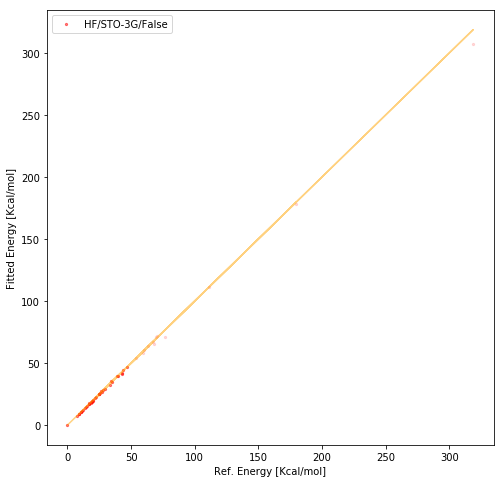

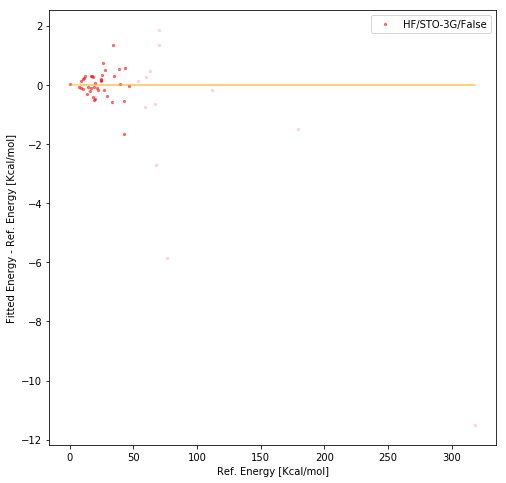

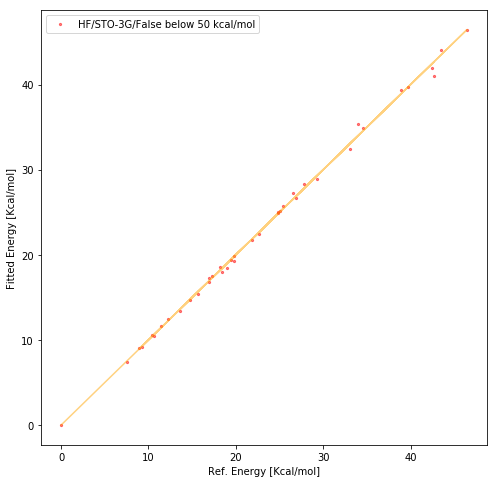

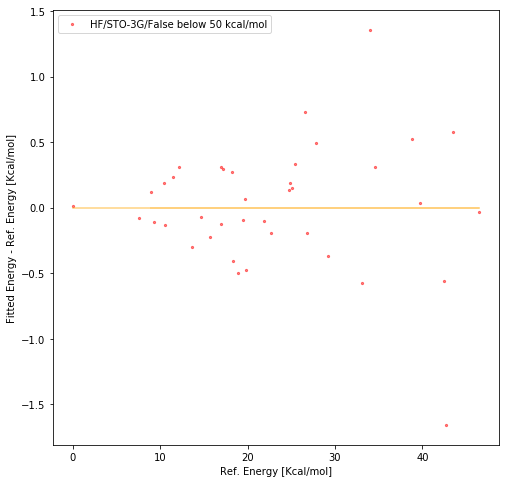

In [23]:
%matplotlib inline
potential_fitting.fitting.fit_visualizer.make_1b_graphs(mon_settings, mbnrg_directory + "/eval-1b", results_prefix + ".nc", database_config, mon_name, method, basis, False, "test")

## 8. Generate files for Clusters Ultimate

Finally, we generate the files that will be needed to add this PEF to Clusters_Ultimate, the energy software. In order to do it, clone the master branch of [Clusters_Ultimate](https://github.com/paesanilab/clusters_ultimate) in the [paesanilab github page](https://github.com/paesanilab) and follow the instructions in the README.

In [24]:
potential_fitting.fitting.generate_software_files_1b(mon_settings, molecule_in, poly_directory, polynomial_order, mbnrg_directory,config,"fit-1b.cdl",mon_id)

mb-nrg_fit/fit-1b.cdl
